# Prepare data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load data
data = pd.read_csv('../data/brca_small.csv', index_col=0)
X = data.values[:, :-1]
Y = data.values[:, -1]
genes = data.columns.tolist()[:-1]
num_genes = len(genes)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=100, random_state=1)

# Normalize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Train model

- Use cross validation to select the optimal parameter for Lasso penalty.

In [3]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [4]:
def fit_model(x, y, x_val, y_val):
    # Cross validate for C
    C_list = np.arange(0.1, 1.0, 0.05)
    best_loss = np.inf
    best_C = None

    for C in C_list:
        # Fit model
        model = LogisticRegression(C=C, penalty='l1', multi_class='multinomial',
                                   solver='saga', max_iter=20000)
        model.fit(x, y)

        # Calculate loss
        val_loss = log_loss(y_val, model.predict_proba(x_val))

        # See if best
        if val_loss < best_loss:
            best_loss = val_loss
            best_C = C
            
    # Train model with all data
    model = LogisticRegression(C=best_C, penalty='l1', multi_class='multinomial',
                               solver='saga', max_iter=10000)
    model.fit(np.concatenate((x, x_val), axis=0),
              np.concatenate((y, y_val), axis=0))
    
    return model

In [5]:
# Train model
original_model = fit_model(X_train, Y_train, X_val, Y_val)

# Train surrogate model

- A surrogate model mimics the original model's predictions when features are held out.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, BatchSampler
from rexplain.torch import MaskLayer1d
from copy import deepcopy
import matplotlib.pyplot as plt

In [7]:
# Custom loss function
class CELoss(nn.Module):
    '''Cross entropy loss for distributional targets. Expects logits.'''
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        return - torch.mean(
            torch.sum(pred.log_softmax(dim=1) * target, dim=1))

In [8]:
# Prepare device
device = torch.device('cuda')

# Prepare training data
X_model = torch.tensor(X_train, dtype=torch.float32)
Y_model = torch.tensor(original_model.predict_proba(X_train),
                       dtype=torch.float32)

In [9]:
# Prepare validation data
Y_val_surrogate = torch.tensor(original_model.predict_proba(X_val).repeat(1000, 0),
                               dtype=torch.float32)
X_val_surrogate = torch.tensor(X_val.repeat(1000, 0), dtype=torch.float32)

# Random subsets
S_val = torch.ones(X_val_surrogate.shape)
num_included = np.random.choice(num_genes + 1, size=len(S_val))
for i in range(len(S_val)):
    S_val[i, num_included[i]:] = 0
    S_val[i] = S_val[i, torch.randperm(num_genes)]

# Create dataset iterator
val_set = TensorDataset(X_val_surrogate, Y_val_surrogate, S_val)
val_loader = DataLoader(val_set, batch_size=25000)

def validate(model):
    '''Measure performance on validation set.'''
    with torch.no_grad():
        # Setup
        mean_loss = 0
        N = 0

        # Iterate over validation set
        for x, y, S in val_loader:
            x = x.to(device)
            y = y.to(device)
            S = S.to(device)
            pred = model((x, S))
            loss = loss_fn(pred, y)
            N += len(x)
            mean_loss += len(x) * (loss - mean_loss) / N

    return mean_loss

In [10]:
# Set up model
model = nn.Sequential(
    MaskLayer1d(value=0),
    nn.Linear(2 * num_genes, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, 4)).to(device)

# Training parameters
lr = 1e-3
nepochs = 1000
early_stop_epochs = 10

# Loss function
loss_fn = CELoss()
loss_list = []

for mbsize in (32, 128, 512, 1024, 2048, 5096, 10192):
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up data loaders
    train_set = TensorDataset(X_model, Y_model)
    random_sampler = RandomSampler(
        train_set, replacement=True,
        num_samples=int(np.ceil(len(X_model) / mbsize))*mbsize)
    batch_sampler = BatchSampler(random_sampler, batch_size=mbsize, drop_last=True)
    train_loader = DataLoader(train_set, batch_sampler=batch_sampler)

    # For saving best model
    min_epoch = 0
    best_model = deepcopy(model)
    best_epoch_loss = validate(model).item()
    best_epoch = 0

    # Begin training
    for epoch in range(nepochs):
        for i, (x, y) in enumerate(train_loader):
            # Prepare data
            x = x.to(device)
            y = y.to(device)

            # Generate subset
            S = torch.ones(mbsize, num_genes, dtype=torch.float32, device=device)
            num_included = np.random.choice(num_genes + 1, size=mbsize)
            for j in range(mbsize):
                S[j, num_included[j]:] = 0
                S[j] = S[j, torch.randperm(num_genes)]

            # Make predictions
            pred = model((x, S))
            loss = loss_fn(pred, y)

            # Optimizer step
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # End of epoch progress message
        val_loss = validate(model).item()
        loss_list.append(val_loss)
        print('----- Epoch = {} -----'.format(epoch + 1))
        print('Val loss = {:.4f}'.format(val_loss))
        print('')

        # Check if best model
        if epoch >= min_epoch:
            if val_loss < best_epoch_loss:
                best_epoch_loss = val_loss
                best_model = deepcopy(model)
                best_epoch = epoch
                print('New best epoch, val loss = {:.4f}'.format(val_loss))
                print('')
            else:
                # Check for early stopping
                if epoch - best_epoch == early_stop_epochs:
                    print('Stopping early')
                    break

    model = best_model

----- Epoch = 1 -----
Val loss = 1.1062

New best epoch, val loss = 1.1062

----- Epoch = 2 -----
Val loss = 0.9705

New best epoch, val loss = 0.9705

----- Epoch = 3 -----
Val loss = 0.8385

New best epoch, val loss = 0.8385

----- Epoch = 4 -----
Val loss = 0.7789

New best epoch, val loss = 0.7789

----- Epoch = 5 -----
Val loss = 0.7389

New best epoch, val loss = 0.7389

----- Epoch = 6 -----
Val loss = 0.7298

New best epoch, val loss = 0.7298

----- Epoch = 7 -----
Val loss = 0.7386

----- Epoch = 8 -----
Val loss = 0.7156

New best epoch, val loss = 0.7156

----- Epoch = 9 -----
Val loss = 0.7012

New best epoch, val loss = 0.7012

----- Epoch = 10 -----
Val loss = 0.6890

New best epoch, val loss = 0.6890

----- Epoch = 11 -----
Val loss = 0.6836

New best epoch, val loss = 0.6836

----- Epoch = 12 -----
Val loss = 0.6833

New best epoch, val loss = 0.6833

----- Epoch = 13 -----
Val loss = 0.6757

New best epoch, val loss = 0.6757

----- Epoch = 14 -----
Val loss = 0.6875

-

----- Epoch = 14 -----
Val loss = 0.6382

----- Epoch = 15 -----
Val loss = 0.6385

----- Epoch = 16 -----
Val loss = 0.6392

----- Epoch = 17 -----
Val loss = 0.6397

----- Epoch = 18 -----
Val loss = 0.6393

----- Epoch = 19 -----
Val loss = 0.6389

----- Epoch = 20 -----
Val loss = 0.6378

----- Epoch = 21 -----
Val loss = 0.6365

New best epoch, val loss = 0.6365

----- Epoch = 22 -----
Val loss = 0.6356

New best epoch, val loss = 0.6356

----- Epoch = 23 -----
Val loss = 0.6352

New best epoch, val loss = 0.6352

----- Epoch = 24 -----
Val loss = 0.6352

New best epoch, val loss = 0.6352

----- Epoch = 25 -----
Val loss = 0.6355

----- Epoch = 26 -----
Val loss = 0.6359

----- Epoch = 27 -----
Val loss = 0.6369

----- Epoch = 28 -----
Val loss = 0.6384

----- Epoch = 29 -----
Val loss = 0.6388

----- Epoch = 30 -----
Val loss = 0.6384

----- Epoch = 31 -----
Val loss = 0.6380

----- Epoch = 32 -----
Val loss = 0.6372

----- Epoch = 33 -----
Val loss = 0.6362

----- Epoch = 34 ---

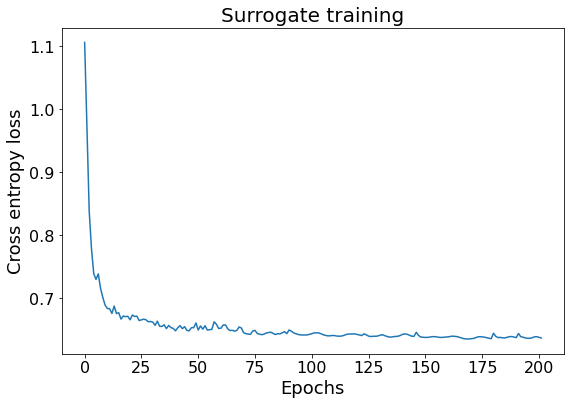

In [11]:
# Plot loss during training
plt.figure(figsize=(9, 6))
plt.plot(loss_list)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross entropy loss', fontsize=18)
plt.tick_params(labelsize=16)
plt.title('Surrogate training', fontsize=20)
plt.show()

# Generate explanations

- Explain dataset loss (rather than individual predictions).

In [12]:
from rexplain import removal, behavior, summary
from rexplain.utils import crossentropyloss

In [13]:
# Make model callable with numpy input
model_lam = lambda x, S: torch.softmax(
    model((torch.tensor(x, dtype=torch.float32, device=device),
           torch.tensor(S, dtype=torch.float32, device=device))),
    dim=1).cpu().data.numpy()

# Model extension
conditional_extension = removal.ConditionalSupervisedExtension(model_lam)

# Cooperative game
game = behavior.DatasetLossGame(conditional_extension, X_test, Y_test, crossentropyloss)

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 12.4 ms


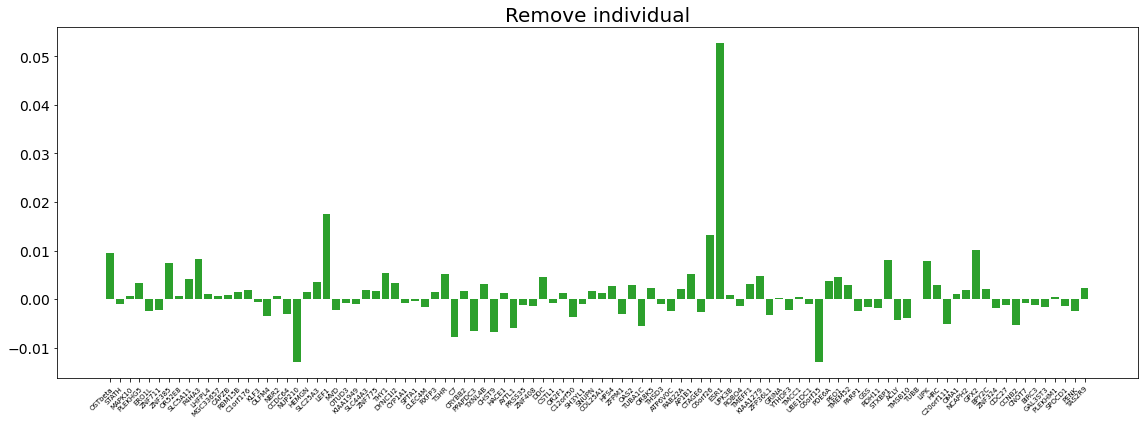

In [14]:
# Summary technique
%time remove_attr = summary.RemoveIndividual(game)

plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(remove_attr)), remove_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(remove_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Remove individual', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 12 s, sys: 17 ms, total: 12 s
Wall time: 1.2 s


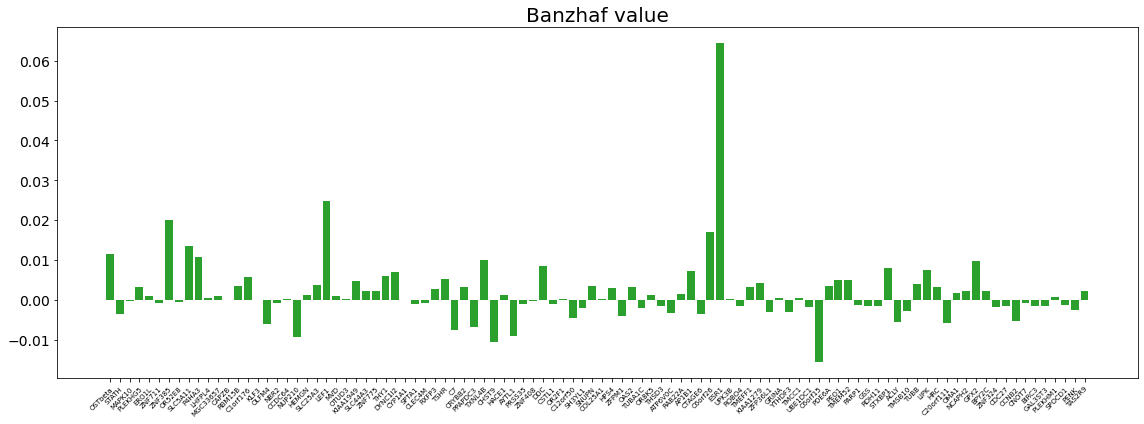

In [15]:
# Summary technique
%time banzhaf_attr = summary.BanzhafValue(game, thresh=0.01)

plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(banzhaf_attr)), banzhaf_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(banzhaf_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Banzhaf value', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 3min 13s, sys: 861 ms, total: 3min 14s
Wall time: 19.5 s


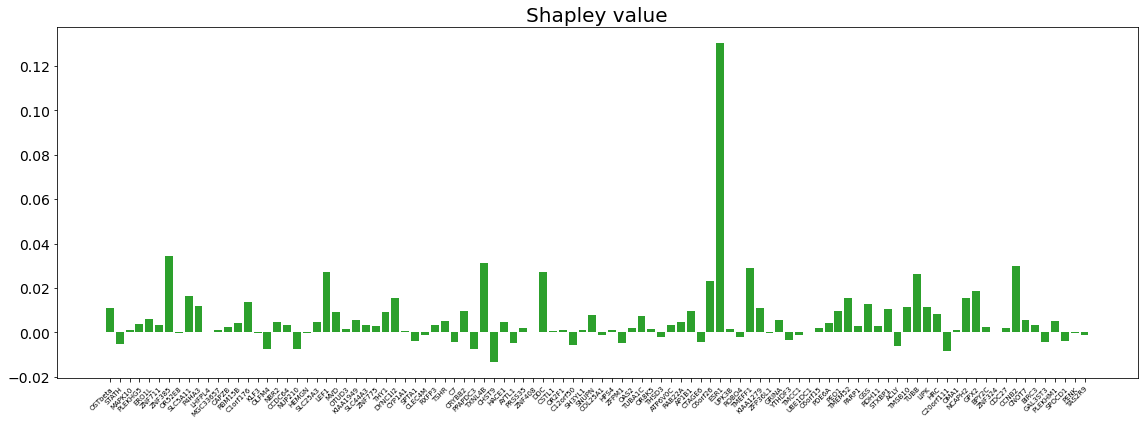

In [16]:
# Summary technique
%time shapley_attr = summary.ShapleyValue(game, thresh=0.01)

plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(shapley_attr)), shapley_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(shapley_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Shapley value', fontsize=20)
plt.tight_layout()
plt.show()

# Most important genes

In [17]:
# Setup
attr_list = [remove_attr, banzhaf_attr, shapley_attr]
attr_names = ['Remove', 'Banzhaf', 'Shapley']
num = 10
loss_list = []

# Train small models
for attr in attr_list:
    # Filter for important genes
    inds = np.argsort(attr)[-num:]
    X_train_small = X_train[:, inds]
    X_val_small = X_val[:, inds]
    X_test_small = X_test[:, inds]

    # Train model
    small_model = fit_model(X_train_small, Y_train, X_val_small, Y_val)
    loss = log_loss(Y_test, small_model.predict_proba(X_test_small))
    loss_list.append(loss)

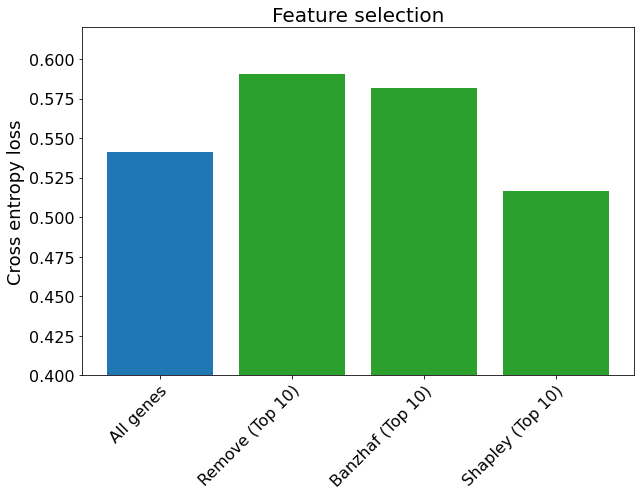

In [18]:
plt.figure(figsize=(9, 7))

plt.bar(np.arange(len(attr_list) + 1),
        [log_loss(Y_test, original_model.predict_proba(X_test))] + loss_list,
        color=['C0'] + ['tab:green' for _ in attr_list])
plt.xticks(np.arange(len(attr_list) + 1),
           ['All genes'] + ['{} (Top {})'.format(name, num) for name in attr_names],
           rotation=45, rotation_mode='anchor', ha='right')
plt.ylabel('Cross entropy loss', fontsize=18)
plt.title('Feature selection', fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(0.4, None)

plt.tight_layout()
plt.show()